In [1]:
%scala 
import java.net.URL
import java.io.File
import org.apache.commons.io.FileUtils

val configs = Map(
  "dfs.adls.oauth2.access.token.provider.type" -> "ClientCredential",
  "dfs.adls.oauth2.client.id" -> "",
  "dfs.adls.oauth2.credential" -> "",
  "dfs.adls.oauth2.refresh.url" -> "")

dbutils.fs.unmount("/mnt/test")
dbutils.fs.mount(
  source = "adl://iunimag.azuredatalakestore.net",
  mountPoint = "/mnt/test",
  extraConfigs = configs)

//val df = spark.read.parquet("adl://iunimag.azuredatalakestore.net/WoS/CORE_2014_2015_Annuals")
display(dbutils.fs.ls("/mnt/test"))

path,name,size
dbfs:/mnt/test/APS/,APS/,0
dbfs:/mnt/test/AssemblyCache_69649510-a785-4907-9a4c-90df33feb8ce/,AssemblyCache_69649510-a785-4907-9a4c-90df33feb8ce/,0
dbfs:/mnt/test/MAGPM-neuro-papers0.tsv,MAGPM-neuro-papers0.tsv,0
dbfs:/mnt/test/MAGPM-neuro-papers1.tsv,MAGPM-neuro-papers1.tsv,18184403
dbfs:/mnt/test/MAGPM-neuro-papers2.tsv,MAGPM-neuro-papers2.tsv,317777391
dbfs:/mnt/test/MAGPM-neuro-refs0.tsv,MAGPM-neuro-refs0.tsv,0
dbfs:/mnt/test/MAGPM-neuro-refs1.tsv,MAGPM-neuro-refs1.tsv,946959
dbfs:/mnt/test/MAGPM-neuro-refs2.tsv,MAGPM-neuro-refs2.tsv,31818323
dbfs:/mnt/test/MAGPM-neuro-test.tsv,MAGPM-neuro-test.tsv,5213
dbfs:/mnt/test/MAG_APS/,MAG_APS/,0


In [2]:
import pyspark.sql.functions as sql
papers = spark.read.format("parquet").load("/mnt/test/graph/2019-1-11-PNAS/papers/*.parquet")
papers.describe().filter(sql.col("summary") == "count").show(20,False)

+-------+------+------+------+------+------+------+---+------+------+------+------+----+----+------+------+------+------+------+------+------+------+------+
summary| _c0| _c1| _c2| _c3| _c4| _c5|_c6| _c7| _c8| _c9| _c10|_c11|_c12| _c13| _c14| _c15| _c16| _c17| _c18| _c19| _c20| _c21|
+-------+------+------+------+------+------+------+---+------+------+------+------+----+----+------+------+------+------+------+------+------+------+------+
 count|138953|138953|135508|138953|138953|138953| 25|138953|138953|135368|138953| 0| 0|135531|135099|133690|127181|138953|138953|138953|138953|138953|
+-------+------+------+------+------+------+------+---+------+------+------+------+----+----+------+------+------+------+------+------+------+------+------+

In [3]:
papers.filter(sql.col("_c0") == "138272679").show(20,False)

+---------+-----+----+-------+----------------------------------------------------------------+-----------------------------------------------------------------+----+----+----------+----+---------+----+----+----+----+----+----+----+----+----+-------------------------------------------------------------------------------+----------+
_c0 |_c1 |_c2 |_c3 |_c4 |_c5 |_c6 |_c7 |_c8 |_c9 |_c10 |_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20 |_c21 |
+---------+-----+----+-------+----------------------------------------------------------------+-----------------------------------------------------------------+----+----+----------+----+---------+----+----+----+----+----+----+----+----+----+-------------------------------------------------------------------------------+----------+
138272679|18612|null|Journal|inaugural article tipping elements in the earth s climate system|Inaugural Article: Tipping elements in the Earth's climate system|null|2008|2008-01-01|null|125754415|null|null|null|null|null|null|81 |77 |116 |Proceedings of the National Academy of Sciences of the United States of America|2016-06-24|
+---------+-----+----+-------+----------------------------------------------------------------+-----------------------------------------------------------------+----+----+----------+----+---------+----+----+----+----+----+----+----+----+----+-------------------------------------------------------------------------------+----------+

In [4]:
citations0 = spark.read.format("parquet").load("/mnt/test/graph/2019-1-11-PNAS/citations/*.parquet")
citations0.write.bucketBy(20, "cited").saveAsTable("citations")
citations = spark.read.table("citations")
citations.describe().filter(sql.col("summary") == "count").show(20)

+-------+--------+--------+
summary| cited| citing|
+-------+--------+--------+
 count|13196809|13196809|
+-------+--------+--------+

In [5]:
oneHop = citations.filter(sql.col("cited") == "138272679").toDF("focal","connector")
twoHops = oneHop.join(citations, (oneHop["connector"] == citations["cited"]), "inner")
oneHop0 = oneHop.toDF("cited2","LE")
ego = twoHops.join(oneHop0, (twoHops["focal"] == oneHop0["cited2"]) & (twoHops["citing"] == oneHop0["LE"]), "inner")
ego.describe().filter(sql.col("summary") == "count").show(20)

+-------+-----+---------+-----+------+------+---+
summary|focal|connector|cited|citing|cited2| LE|
+-------+-----+---------+-----+------+------+---+
 count| 34| 34| 34| 34| 34| 34|
+-------+-----+---------+-----+------+------+---+

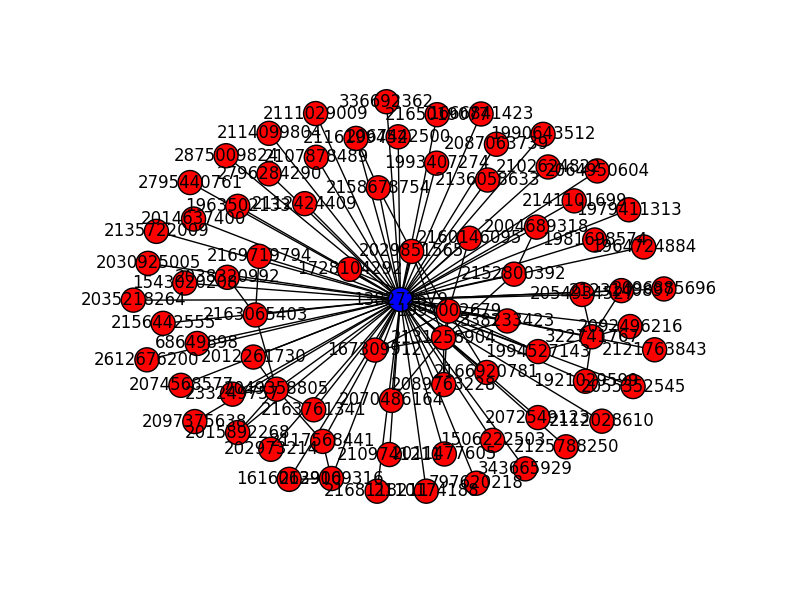

In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

subgraph = oneHop.select("focal","connector").distinct().toPandas()
subgraph = subgraph.append(ego.select("connector","LE").toDF("focal","connector").distinct().toPandas())
G = nx.from_pandas_edgelist(subgraph, "focal", "connector")
pos = nx.spring_layout(G)
color_map = []
for node in G:
    if node == "138272679":
        color_map.append('blue')
    else: color_map.append('red')    
nx.draw(G, node_color = color_map, with_labels=True, pos=pos)
image = plt.show()
display(image)
plt.close()

In [7]:
egos = citations.toDF("focal","connector")
egos2 = egos.join(citations, (egos["connector"] == citations["cited"]), "inner")
egos2.describe().filter(sql.col("summary") == "count").show(20)

+-------+--------+---------+--------+--------+
summary| focal|connector| cited| citing|
+-------+--------+---------+--------+--------+
 count|23133144| 23133144|23133144|23133144|
+-------+--------+---------+--------+--------+

In [8]:
egos0 = citations.toDF("cited2","LE")
egos3 = egos2.join(egos0, (egos2["focal"] == egos0["cited2"]) & (egos2["citing"] == egos0["LE"]), "inner")
egos3.describe().filter(sql.col("summary") == "count").show(20)

+-------+-------+---------+-------+-------+-------+-------+
summary| focal|connector| cited| citing| cited2| LE|
+-------+-------+---------+-------+-------+-------+-------+
 count|2457764| 2457764|2457764|2457764|2457764|2457764|
+-------+-------+---------+-------+-------+-------+-------+

In [9]:
egos3.show(50)

+----------+----------+----------+----------+----------+----------+
 focal| connector| cited| citing| cited2| LE|
+----------+----------+----------+----------+----------+----------+
 106068140|1968707255|1968707255|2115398513| 106068140|2115398513|
 138272679|2131258904|2131258904|2089763228| 138272679|2089763228|
 138272679|1994002679|1994002679|2089763228| 138272679|2089763228|
 138272679|2163065403|2163065403|2169719794| 138272679|2169719794|
 138530214|2130983257|2130983257|2070686757| 138530214|2070686757|
 138771147|2166678085|2166678085|1533897498| 138771147|1533897498|
 138771147|2781498816|2781498816|2068464578| 138771147|2068464578|
1485683953|1986628169|1986628169|1835928992|1485683953|1835928992|
1491559418|2057748410|2057748410|2781979622|1491559418|2781979622|
1496367743|2050298867|2050298867|2146460938|1496367743|2146460938|
1499129442|2016399990|2016399990|2018276385|1499129442|2018276385|
1499342446|2559324192|2559324192|2773685302|1499342446|2773685302|
1503765703|2078108096|2078108096|2053549636|1503765703|2053549636|
1503765703|2157687771|2157687771|2131332433|1503765703|2131332433|
1507443353|2109369115|2109369115|2121123663|1507443353|2121123663|
1510144437|2007572953|2007572953|2106080677|1510144437|2106080677|
1511237419|2152217159|2152217159|1567372955|1511237419|1567372955|
1511237419|2136356801|2136356801|1567372955|1511237419|1567372955|
1511853190|2120922679|2120922679|2170110939|1511853190|2170110939|
1511853190|2131305117|2131305117|2170110939|1511853190|2170110939|
1513896494|2141641837|2141641837|2618871997|1513896494|2618871997|
1516412274|1973269530|1973269530|2000660230|1516412274|2000660230|
1516412274|2153676981|2153676981|2008812368|1516412274|2008812368|
1523590178|2083093742|2083093742| 184807859|1523590178| 184807859|
1528276801|2159013299|2159013299|1554182554|1528276801|1554182554|
1528276801|2136549983|2136549983|2096744050|1528276801|2096744050|
1528276801|1982585264|1982585264|2104640632|1528276801|2104640632|
1528276801|2136549983|2136549983|2104640632|1528276801|2104640632|
1531468991|2022408178|2022408178|2062132232|1531468991|2062132232|
1531468991|2113979580|2113979580|2062132232|1531468991|2062132232|
1531468991|2137668153|2137668153|2062132232|1531468991|2062132232|
1535438232|2014460650|2014460650|2124008135|1535438232|2124008135|
1539467957|2000741536|2000741536|1566898963|1539467957|1566898963|
1539467957|2147352258|2147352258|1566898963|1539467957|1566898963|
1542159434|2014503023|2014503023| 215870214|1542159434| 215870214|
1542159434|2161456325|2161456325| 215870214|1542159434| 215870214|
1550089989|2101385475|2101385475|2033115253|1550089989|2033115253|
1550089989|1668784512|1668784512|2890910464|1550089989|2890910464|
1550140963|2079357894|2079357894|2056129658|1550140963|2056129658|
1550140963|2033079756|2033079756|2056129658|1550140963|2056129658|
1575707379|2034188327|2034188327|2021506323|1575707379|2021506323|
1579034878|2028333071|2028333071|2530836964|1579034878|2530836964|
1586960880|2078573205|2078573205|1002761214|1586960880|1002761214|
1586960880|2124466936|2124466936|1002761214|1586960880|1002761214|
1594833373|1999498230|1999498230|1977302570|1594833373|1977302570|
1594833373|1999498230|1999498230|1995869668|1594833373|1995869668|
1609504261|1990437529|1990437529|2026577388|1609504261|2026577388|
1610919278|1967955038|1967955038|1968875970|1610919278|1968875970|
1613296122|2100605824|2100605824|2105910460|1613296122|2105910460|
1613296122|2004650415|2004650415|2105910460|1613296122|2105910460|
+----------+----------+----------+----------+----------+----------+
only showing top 50 rows

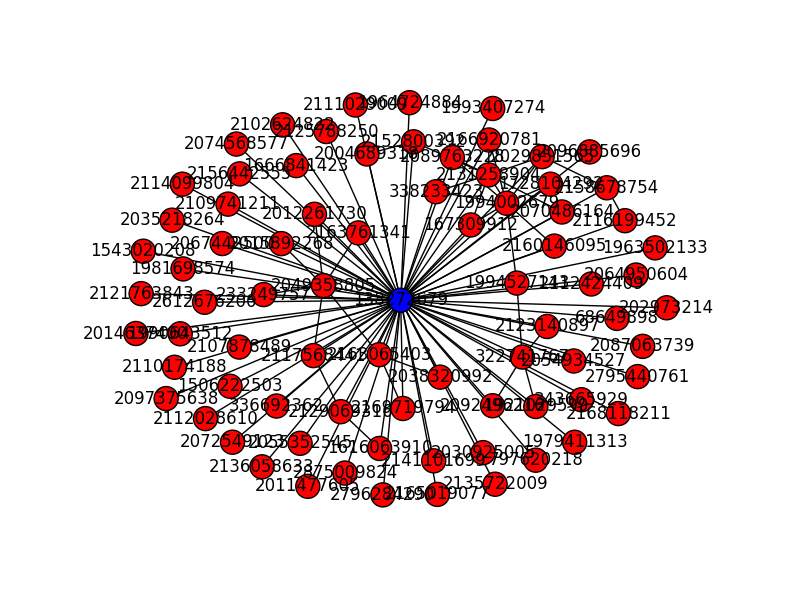

In [10]:
oneHop = egos.filter(sql.col("focal") == "138272679")
ego = egos3.filter(sql.col("focal") == "138272679")

subgraph = oneHop.select("focal","connector").distinct().toPandas()
subgraph = subgraph.append(ego.select("connector","LE").toDF("focal","connector").distinct().toPandas())
G = nx.from_pandas_edgelist(subgraph, "focal", "connector")
pos = nx.spring_layout(G)
color_map = []
for node in G:
    if node == "138272679":
        color_map.append('blue')
    else: color_map.append('red')    
nx.draw(G, node_color = color_map, with_labels=True, pos=pos)
image = plt.show()
display(image)
plt.close()